In [14]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.05, 1.05]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

In [15]:
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.3]
model.copula_parameters = theta
model.shapley_indices = [1./dim]*dim
if dim == 2 and beta is None:
    output_var = dim*( 1 + sum(theta))
    model.first_order_sobol_indices = [(1 + 2*theta[0] + theta[0]**2)/output_var]*dim
    model.total_sobol_indices = [(1.- theta[0]**2)/output_var]*dim

In [38]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
theta = [0., 0., 0.9]
model.copula_parameters = theta

## Sobol indices with a classical Monte-Carlo sampling

In [152]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_perms = 6000
Nv = 10000
No = 100
Ni = 100

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

In [153]:
n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

In [154]:
shapley_results.true_first_indices = model.first_order_sobol_indices
shapley_results.true_total_indices = model.total_sobol_indices
shapley_results.true_shapley_indices = model.shapley_indices

There is no true first order sobol indices
There is no true first order sobol indices
There is no true first order shapley effect.


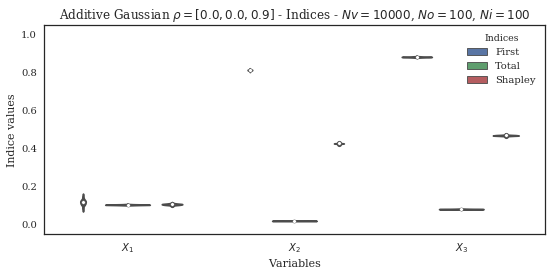

In [155]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_additive_gaussian.pdf')

In [156]:
def get_confidence_interval(results, quantiles=[2.5, 97.5]):
    """
    """
    interval = 2*results[:, 0].T - np.percentile(results, quantiles[::-1], axis=1)
    return interval.T

In [157]:
get_confidence(shapley_results.full_shapley_indices)

array([[ 0.09520808,  0.10768633],
       [ 0.42523183,  0.42997883],
       [ 0.46710229,  0.47484478]])

In [158]:
get_confidence(shapley_results.full_first_indices)

array([[ 0.07524119,  0.12340713],
       [ 0.80267861,  0.81300455],
       [ 0.87490001,  0.88142214]])

In [159]:
get_confidence(shapley_results.full_total_indices)

array([[ 0.10316494,  0.10886362],
       [ 0.01880922,  0.01985901],
       [ 0.08015453,  0.0845784 ]])

## Krigin Model

In [ ]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 10
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'monte-carlo'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [ ]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
Nv = 500
No = 50
Ni = 25
n_realization = 50

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

In [ ]:
n_boot_var = 30
n_boot_No = 30
n_boot_Ni = 30
shapley_kriging_results = shapley_kriging.compute_indices(n_boot_var=n_boot_var, 
                                         n_boot_No=n_boot_No,
                                         n_boot_Ni=n_boot_Ni)

In [ ]:
shapley_kriging_results.true_first_indices = model.first_order_sobol_indices
shapley_kriging_results.true_total_indices = model.total_sobol_indices
shapley_kriging_results.true_shapley_indices = model.shapley_indices

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')